2. House prices:

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

Load the houseprices data from Thinkful's database.
Reimplement the model you built in the previous checkpoint.
Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
be sure to close the database connection after initially pulling in your data.

In [1]:
# Import some libraries and packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Connect to the data base:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format( postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

In [3]:
# Look at the dataset:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.00,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# Look at the type of each column:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Fisrt, I choose two categorical variables. The categorical variables are strings and we need to convert them to numerical values.

In [5]:
# I convert two categorical variables to numbers and concat to dataset:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.utilities, prefix="utilities", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns) + list(pd.get_dummies(df.utilities, prefix="utilities", drop_first=True).columns)


Now modeling the saleprice houses with linear regression.I choose two (???? I didnt know how many????) weak correlationship variables between target variable and continuse variables; also, I choose two categorical variables (????? i didnt know how to choose and how many???) then using all of them to model.  

saleprice:y = 𝛽0+𝛽1 threessnporch + 𝛽2 mosold + 𝛽3 mszoning + 𝛽4 utilities + 𝜖

In [6]:
# Now we build a simple linear regression model and estimate it using OLS:

# Y is the target variable:
Y = df['saleprice']
# X is the feature set which includes: threessnporch, mosold and dummy columns:
X = df[['threessnporch','mosold'] + dummy_column_names]

# We create a LinearRegression model with statsmodels' sm linear_model module.

# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

# fit method estimates the coefficients using OLS
results = sm.OLS(Y,  X).fit()

# Inspect the results.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     25.98
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           1.13e-33
Time:                        02:02:44   Log-Likelihood:                -18458.
No. Observations:                1460   AIC:                         3.693e+04
Df Residuals:                    1452   BIC:                         3.697e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6.348e+04   2.44e+04      2.602      0.009    1.56e+04    1.11e+05
threessnporch       84.8014     67.158      1.263      0.207     -46.936     216.539
mosold            1435.3758    729.741      1.967      0.049       3.916    2866.835
mszoning_FV       1.415e+05   2.55e+04      5.545      0.000    9.15e+04    1.92e+05
mszoning_RH       5.732e+04   3.03e+04      1.894      0.058   -2045.410    1.17e+05
mszoning_RL       1.181e+05   2.39e+04      4.950      0.000    7.13e+04    1.65e+05
mszoning_RM       5.387e+04   2.43e+04      2.217      0.027    6195.085    1.02e+05
utilities_NoSeWa -4.556e+04   7.52e+04     -0.606      0.545   -1.93e+05    1.02e+05
==============================================================================
Omnibus:                      692.221   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5041.452
Skew:                           2.081   Prob(JB):                         0.00
Kurtosis:                      11.096   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, check if the model meets the Gauss-Markov Conditions:
    
1.Assumption one: linearity of the model in its coefficients:
The first assumption that must be met is that the target variable should be a linear function of the model's coefficients.
The relationship could be quadratic or higher order. A model like 𝑦=𝛽0+𝛽1𝑥1+𝛽2𝑥2^2+𝜖 is completely valid:
So,modeling the saleprice houses with linear regression is:

saleprice:y = 63480 + 84.8014 threessnporch + 1435.3758 mosold + 370790 mszoning - 45560 utilities 	
???? is it correct all mszoing add together or not????

As you can see here, the target variable is a linear function of the model's coeficients.???? correct??/

2.Assumption two: the error term should be zero on average:
The error term accounts for the variation in the target variable that is not explained by the features. As long as we include a constant in a model, we shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

In [7]:
# To see mean of the errors in the saleprice houses model:
predictions = results.predict(X)
errors = Y - predictions

print("Mean of the errors in the saleprice houses model is: {}".format(np.mean(errors)))

Mean of the errors in the saleprice houses model is: 2.6354714526399356e-09


Since, we include the constant term in the model, the average of the model's error is effectively zero.

3.Assumption three: homoscedasticity:

A model is homoscedastic when the error variance shouldn't systematically change across observations. When this assumption is not met, we are dealing with heteroscedasticity. Thankfully, there are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms. Here, we demonstrate two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic.

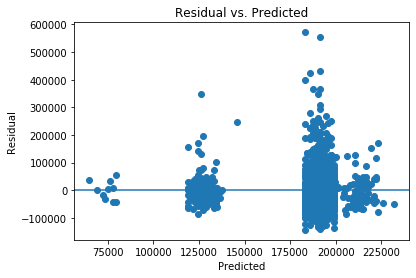

In [8]:
# First, let's checkout whether saleprice houses model suffers from heteroscedasticity by visualizing it:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It seems that error variance is higher for the higher values of the target variable. This implies that our error terms aren't homoscedastic.

In [9]:
# Now check with statistical test:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 1352.27 and p value is 4.96e-296
Levene test statistic value is 508.046 and p value is 7.57e-104


The p-values of both tests are 0. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

Some fixes to heteroscedasticity include transforming the dependent variable by boxcox transformation or log transformations and adding features that target the poorly-estimated areas. But Box-Cox and log transformations only work when all datapoints are positive. so the only way is adding adding features that target the poorly-estimated areas.

4.Assumption four: low multicollinearity: Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. To detect multicollinearity, we can simply look at the correlation matrix of the features.

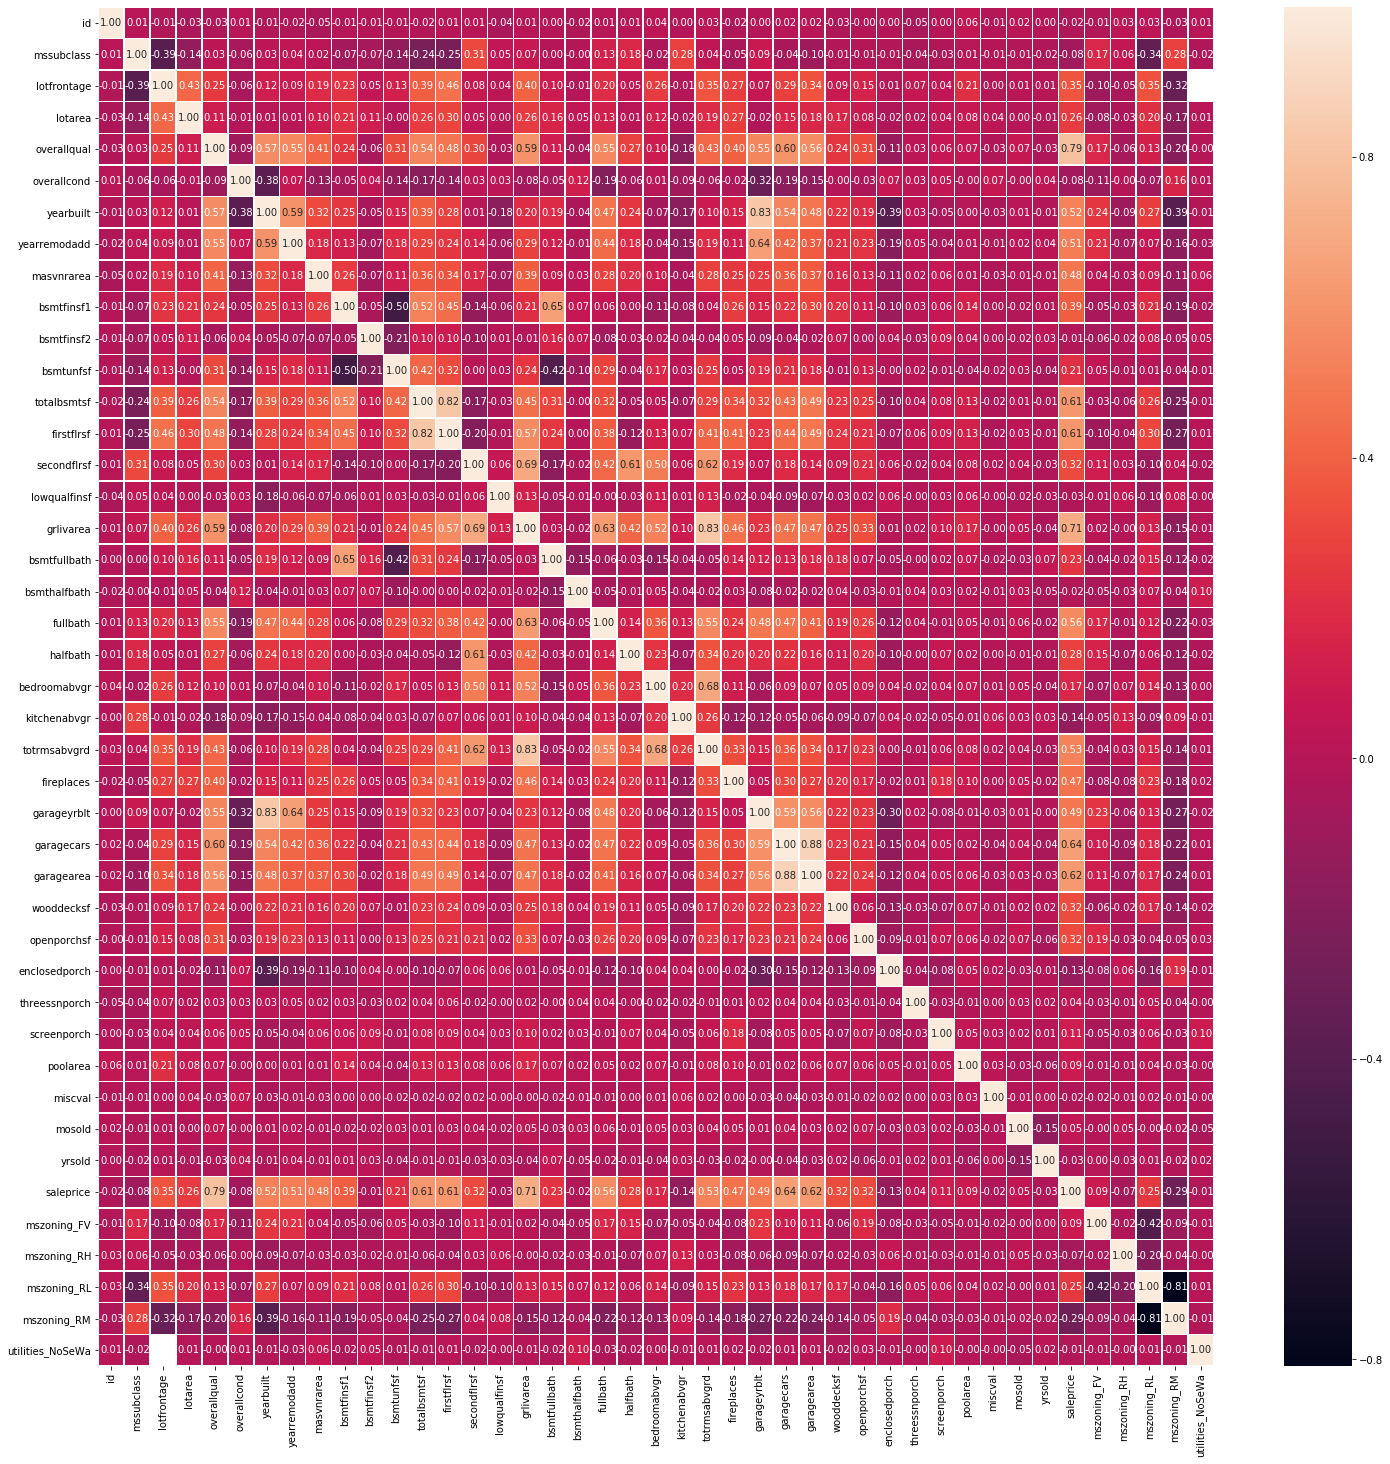

In [10]:
# Using heatmap plot to look at the correlation matrix of the features.
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f')

As you can see features have very low correlation with each other except mzoning dummies features. Also, features have very low correlation with target variable.
Also, if there is correlation of 1 or -1 between a variable and another or several variables, this is called perfect multicollinearity.  

Multicollinearity can be fixed by by discarding some of the correlated features such as mzoning dummies or PCA. ?????correct???

5.Assumption five: error terms should be uncorrelated with one another:

Error terms should be uncorrelated with one another. In other words, the error term for one observation shouldn't predict the error term for another. To identify whether the error terms are correlated with each other or not, we can graph them. In the graph, we need to observe randomness.

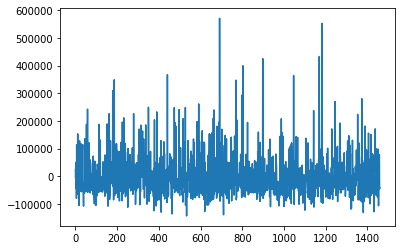

In [11]:
# Check error terms are correlated with each other or not:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

Another way to look at correlations between errors is to use the autocorrelation function. This function computes the correlation of a variable with itself.

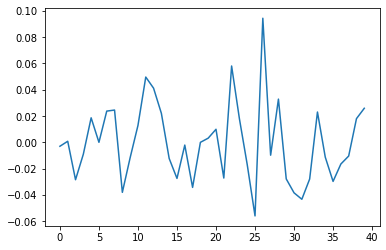

In [12]:
# Look at correlations between errors by using the autocorrelation function:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of our saleprice houses model is indeed very low (ranging between -0.06 and 0.1) ???correct???

6.Assumption six: features shouldn't be correlated with the errors: Explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the exogeneity.

Common causes are omitted variables and simultaneous causation between independent variables and the target.

???? I dont know how to check this assumption???????

Another important thing to consider is the normality of the error terms. In order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

More often than not, non-normally distributed errors stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

There are various ways to check for normality of error terms. An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

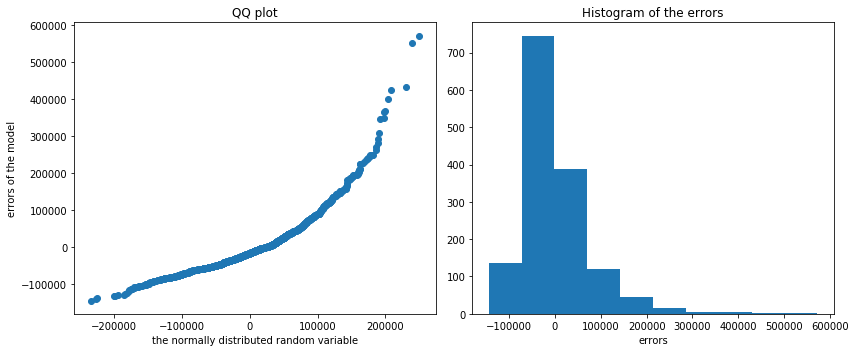

In [13]:
# Look at the QQ plot andhistogram to visualize errors distribution:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors are not normally distributed exactly. The QQ plot and the histogram imply that the distribution is not normal.??? i think far from normal???correct???

We apply formal statistical tests: Jarque Bera and normal tests.

The null hypothesis of both tests is that the errors are normally distributed.

In [14]:
# Now check with statistical test:

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 5041.451525985379 and p value is 0.0
Normality test statistics is 692.2210476891904 and p value is 4.854107227021394e-151


The p-values of both tests indicate that our errors are not normally distributed.